# How predictable are the impacts of specific chemical pollutants on different bacterial communities?

Tom Smith Feb 2024

Some basic analyses looking at how community composition changes with specific chemicals, and whether this is consistent across communities.

Microbial communities were grown for 3 days in media supplemented with combinations of 8 chemical stressors. Optical density was measured every hour for the duration. At the final timepoint, communities were frozen at -80C. We extracted DNA and sequenced a subset of those communities to look at changes in composition. These sequenced communities were controls, each single chemical treatment, four 2-chemical treatments, 2 4-chemical treatments, and the 8-chemical treatment, such that the smaller chemical mixtures are subsets of the larger.

In [1]:
# load some useful packages
library(qiime2R)
library(tidyverse)
library(dplyr)
library(vegan)
library(ggrepel)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.0
✔ tibble  3.2.1     ✔ dplyr   1.1.4
✔ tidyr   1.2.1     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4



In [8]:
# load in the sequencing data (ASV table)
SVs <- read_qza("../data/Earlham/rarefied_table.qza")$data

# transform matrix for vegan
rarefied_OTUs_t <- t(SVs)

# load in the metadata
metadata <- read.csv("../data/Earlham/metadata.tsv", sep = "\t") %>%
  rename(SampleID = sample.id)

metadata[metadata$chem.code == "",]$chem.code <- "Control"

# load in the taxonomy
taxonomy <- read_qza("../data/Earlham/taxonomy.qza")$data %>% parse_taxonomy()

# load in the phylogeny
tree <- read_qza("../data/Earlham/rooted_tree.qza")$data

# create a plotting theme so we can actually read the axes
main_theme <- theme_bw() + theme(axis.text = element_text(size = 16),
                                 axis.title = element_text(size = 20),
                                 strip.text = element_text(size = 16),
                                title = element_text(size = 20))

# Principal Coordinates Analysis (PCoA)

We can start with an ordination to look at where the communities lie in reduced dimensionality space.

Joining with `by = join_by(SampleID)`


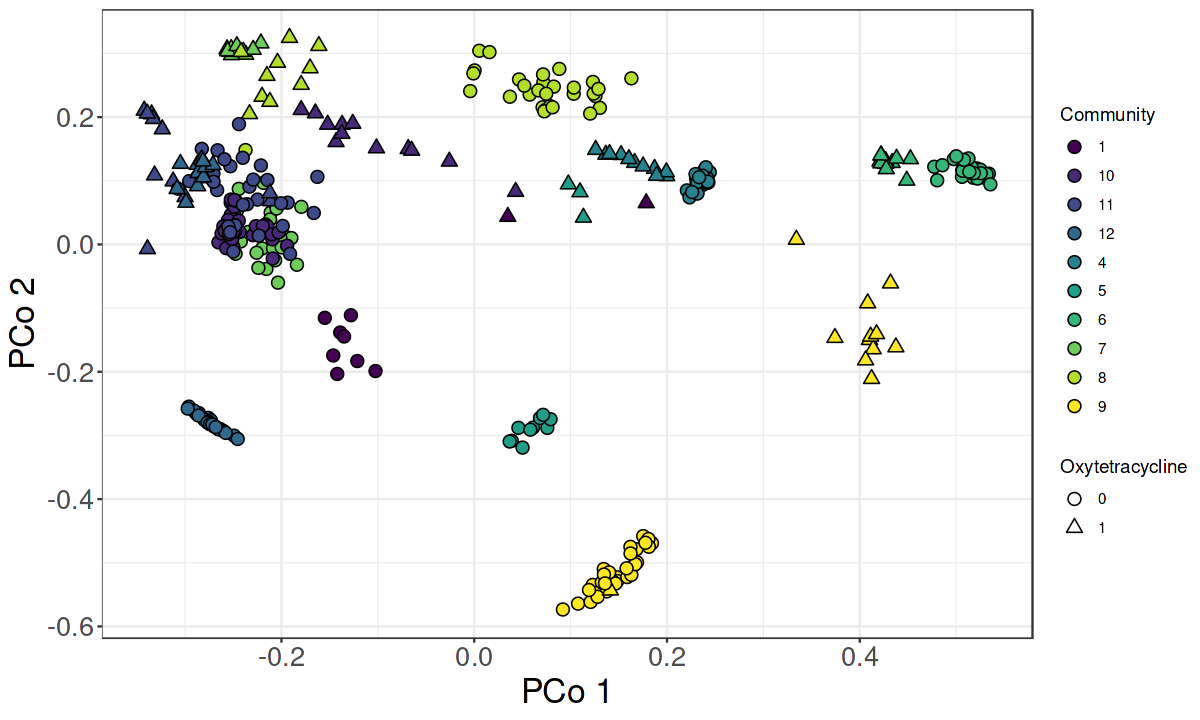

In [6]:
# try PCoA
pco <- wcmdscale(vegdist(rarefied_OTUs_t), eig = TRUE)

## get PCoA scores
scrs <- vegan::scores(pco, choices = 1:2)

# make it a datafrane
pco.df <- data.frame(scrs)
pco.df$SampleID <- rownames(pco.df)

# re-add the metadata
pco.df <- left_join(pco.df, metadata)

options(repr.plot.width = 10, repr.plot.height = 6) # seetting plot size in jupyter

# plot PCoA
pco_plot <- ggplot(pco.df %>% filter(chem.code != "Frozen Starting Community"), aes(x = Dim1, y = Dim2, fill = as.character(community.number))) + 
  geom_point(aes(shape = as.character(Oxytetracycline)), size = 3) +
  scale_shape_manual(values = c(21, 24)) + 
  scale_fill_viridis_d() +
  labs(x = "PCo 1", y = "PCo 2", fill = "Community", shape = "Oxytetracycline") +
  guides(fill = guide_legend(override.aes = list(shape = 21))) +
  main_theme
pco_plot

The different communities (represented by different colours) sit in different areas of the reduced dimensionality space. Once again we see oxytetracycline (triangles) is a strong driver of community composition but it doesn't seem super consistent in how it changes composition across the different communities.

Lets take a look more specifically at all the chemicals and chemical mixtures.

Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


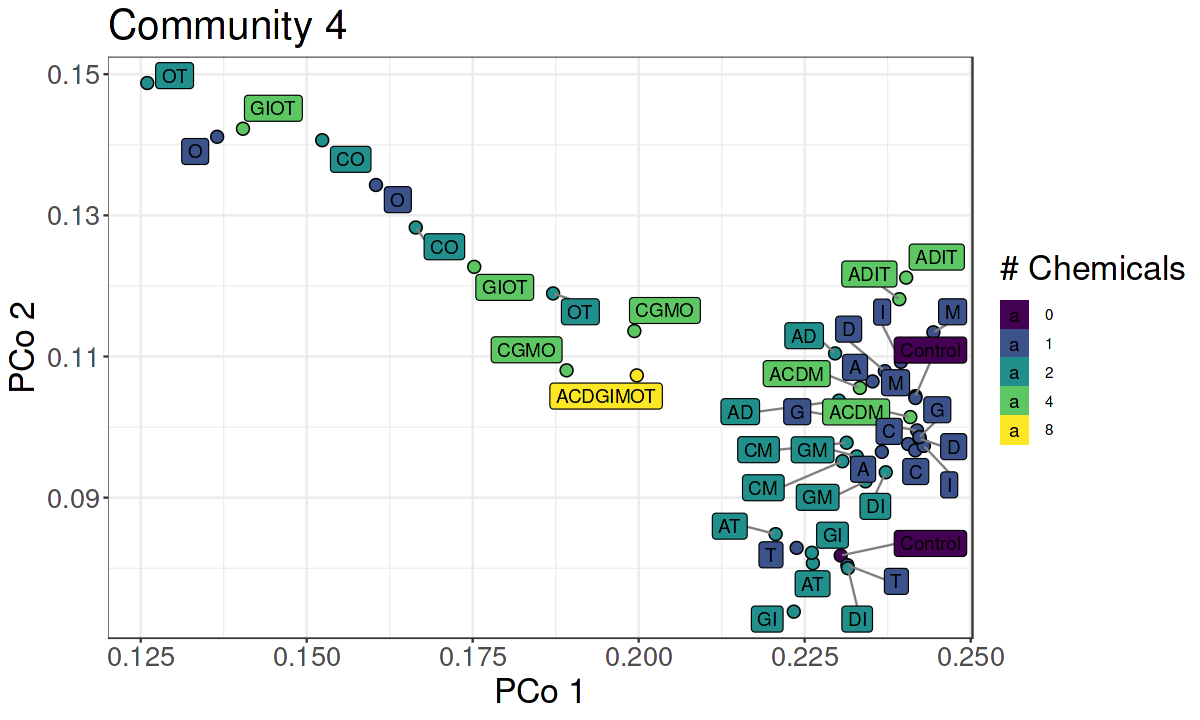

Warning message:
“ggrepel: 15 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


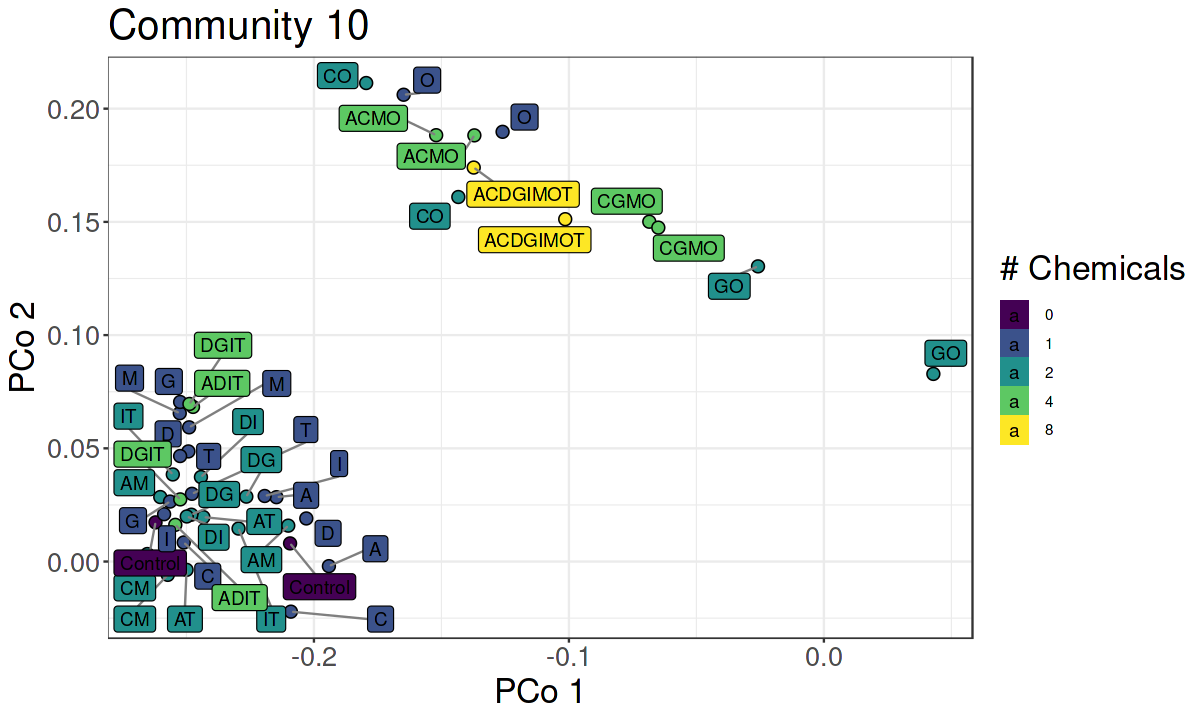

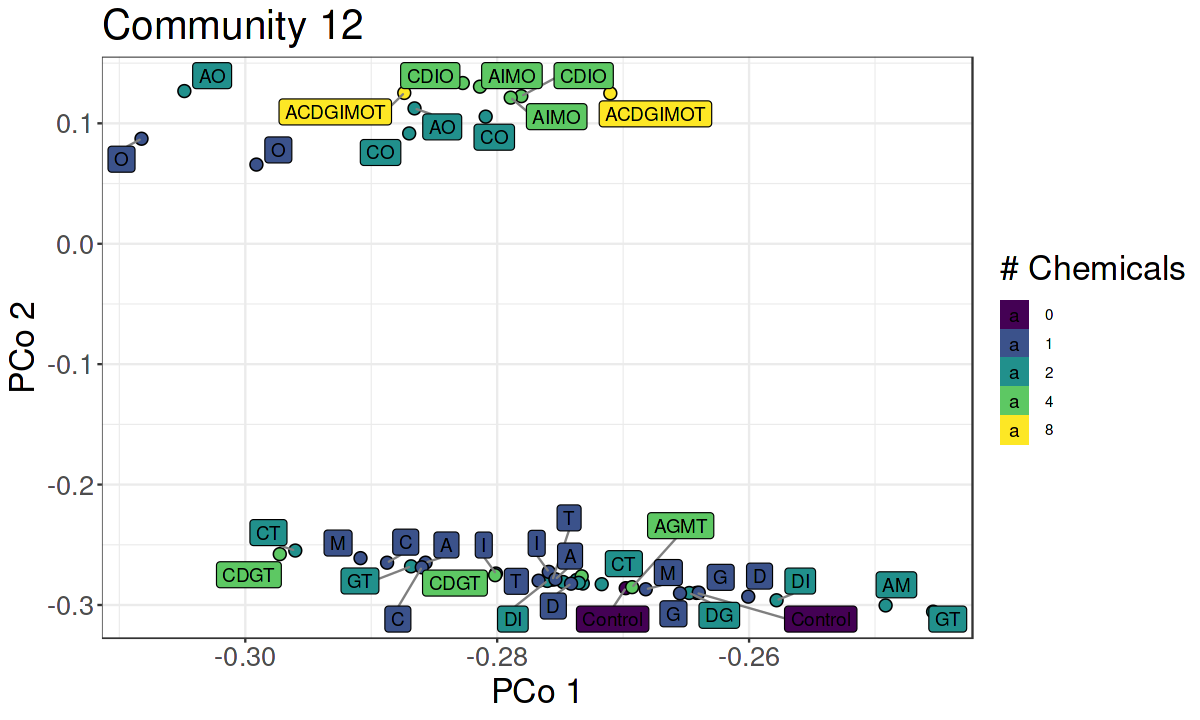

In [9]:
ggplot(pco.df %>% filter(community.number == 4 & chem.code != "Frozen Starting Community"), 
       aes(x = Dim1, y = Dim2, fill = as.character(complexity))) + 
  geom_point(shape = 21, size = 3) +
  geom_label_repel(aes(label = chem.code),
                   segment.color = 'grey50',
                   max.overlaps = 20) +
  scale_fill_viridis_d() +
  labs(x = "PCo 1", y = "PCo 2", fill = "# Chemicals", title = "Community 4") +
  main_theme

ggplot(pco.df %>% filter(community.number == 10 & chem.code != "Frozen Starting Community"), 
       aes(x = Dim1, y = Dim2, fill = as.character(complexity))) + 
  geom_point(shape = 21, size = 3) +
  geom_label_repel(aes(label = chem.code),
                   segment.color = 'grey50',
                   max.overlaps = 20) +
  scale_fill_viridis_d() +
  labs(x = "PCo 1", y = "PCo 2", fill = "# Chemicals", title = "Community 10") +
  main_theme

ggplot(pco.df %>% filter(community.number == 12 & chem.code != "Frozen Starting Community"), 
       aes(x = Dim1, y = Dim2, fill = as.character(complexity))) + 
  geom_point(shape = 21, size = 3) +
  geom_label_repel(aes(label = chem.code),
                   segment.color = 'grey50',
                   max.overlaps = 20) +
  scale_fill_viridis_d() +
  labs(x = "PCo 1", y = "PCo 2", fill = "# Chemicals", title = "Community 12") +
  main_theme

The labels represent the chemical mixtures. The controls (no chemicals) are in purple. Microcosms with more chemical additions go up the scale from blue, to greens, to finally the 8-chemical mixture in yellow. There should be 2 replicates of each condition present, if there isn't, something in the DNA extraction or sequencing didn't work, so that sample got excluded.

We can see the clustering of oxytetracycline mixtures (containing "O") away from the other chemicals, which cluster near the controls. Replicated chemical conditions tend to sit near to each other in the PCo space, this is reassuring. However, the chemicals don't necessarily seem to be moving the communities in the same way along these axes.

We can do some analysis to figure out if the chemicals are having a substantial change in community composition.


# PERMANOVA

Permanova is a good place to start.

In [12]:
# need the OTU table with OTUs as columns, samples as rows.
# then need the metadata table in the same order with samples as rows.

# probably need to chop it down to not include those frozen starting community sequences.
rarefied_metadata <- metadata %>% filter(SampleID %in% rownames(rarefied_OTUs_t),
                                         chem.code != "Frozen Starting Community")

rarefied_OTUs_t <- rarefied_OTUs_t[rarefied_metadata$SampleID,]

# rownames(rarefied_OTUs_t) == rarefied_metadata$SampleID
# sorted

# now try the adonis permanova
# number of chemicals
adonis2(rarefied_OTUs_t ~ community.name + complexity,
                data = rarefied_metadata, method = "bray")

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
community.name,9,83.145666,0.78867045,160.91491,0.001
complexity,1,1.898267,0.01800584,33.06409,0.001
Residual,355,20.381173,0.19332371,NA,NA
Total,365,105.425106,1.00000000,NA,NA


Cool, we can say the number of chemicals has an impact on the community composition. How about the individual chemicals?

In [13]:
adonis2(rarefied_OTUs_t ~ community.name + Amoxicillin + Chlorothalonil + Diflufenican +
                  Glyphosate + Imidacloprid + Metaldehyde + Oxytetracycline + Tebuconazole,
                data = rarefied_metadata, method = "bray")

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
community.name,9,83.14566609,0.7886704508,215.711725,0.001
Amoxicillin,1,0.34126779,0.0032370638,7.968415,0.001
Chlorothalonil,1,0.73893439,0.0070090932,17.253711,0.001
Diflufenican,1,0.05971214,0.0005663940,1.394246,0.214
Glyphosate,1,0.19598201,0.0018589691,4.576072,0.001
Imidacloprid,1,0.41191459,0.0039071774,9.617979,0.001
Metaldehyde,1,0.04532294,0.0004299065,1.058266,0.356
Oxytetracycline,1,5.51057282,0.0522700239,128.668841,0.001
Tebuconazole,1,0.07174179,0.0006805000,1.675131,0.105


Well, 5 of the 8 chemicals seem to have a significant impact on the community composition. What about interactions in the mixtures?

In [14]:
adonis2(rarefied_OTUs_t ~ community.name + (Amoxicillin + Chlorothalonil + Diflufenican +
                                                      Glyphosate + Imidacloprid + Metaldehyde + Tebuconazole) * Oxytetracycline ,
                data = rarefied_metadata, method = "bray")

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
community.name,9,83.14566609,0.7886704508,232.454618,0.001
Amoxicillin,1,0.34126779,0.0032370638,8.586899,0.001
Chlorothalonil,1,0.73893439,0.0070090932,18.592892,0.001
Diflufenican,1,0.05971214,0.0005663940,1.502463,0.168
Glyphosate,1,0.19598201,0.0018589691,4.931253,0.001
Imidacloprid,1,0.41191459,0.0039071774,10.364497,0.001
Metaldehyde,1,0.04532294,0.0004299065,1.140405,0.319
Tebuconazole,1,0.07884589,0.0007478853,1.983902,0.069
Oxytetracycline,1,5.50346872,0.0522026386,138.476977,0.001


So there's also a load of significant interactions in paired mixtures with oxytetracycline, that complicates the picture. What abount interactions by community?

In [15]:
adonis2(rarefied_OTUs_t ~ community.name * (Amoxicillin + Chlorothalonil + Diflufenican +
                  Glyphosate + Imidacloprid + Metaldehyde + Oxytetracycline + Tebuconazole),
                data = rarefied_metadata, method = "bray")

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
community.name,9,83.14566609,0.7886704508,548.1748532,0.001
Amoxicillin,1,0.34126779,0.0032370638,20.2496399,0.001
Chlorothalonil,1,0.73893439,0.0070090932,43.8457881,0.001
Diflufenican,1,0.05971214,0.0005663940,3.5431103,0.003
Glyphosate,1,0.19598201,0.0018589691,11.6288886,0.001
Imidacloprid,1,0.41191459,0.0039071774,24.4415746,0.001
Metaldehyde,1,0.04532294,0.0004299065,2.6893053,0.009
Oxytetracycline,1,5.51057282,0.0522700239,326.9781616,0.001
Tebuconazole,1,0.07174179,0.0006805000,4.2569074,0.004


OK, so I guess by PERMANOVA we can agree that these chemicals alter the community in different ways and the effects are community dependent.

Can we look at specifically which ASVs are indicators for different chemicals?


# Random Forest Models

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin



Attaching package: ‘caret’


The following object is masked from ‘package:vegan’:

    tolerance


The following object is masked from ‘package:purrr’:

    lift




[1] 809 374

[1]  91 374

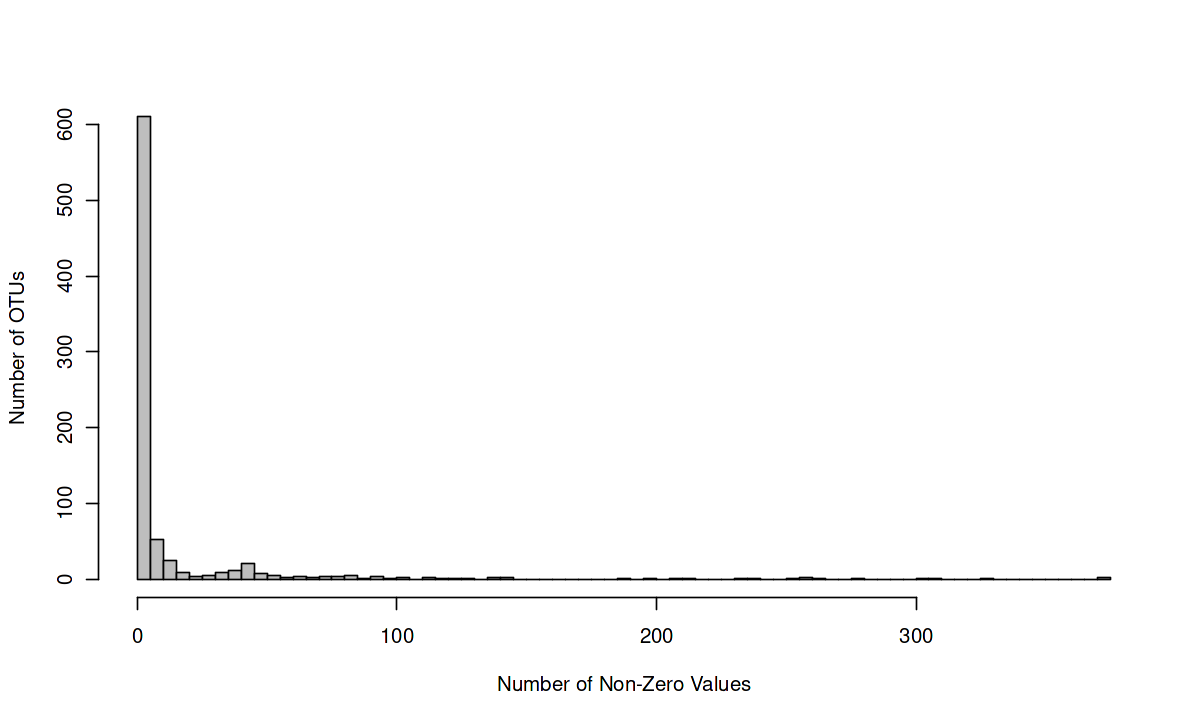

In [16]:
library(randomForest) # packages for random forest models
library(rfUtilities) # for permutation significance testing
library(caret) # to get leave-one-out cross-validation accuracies

# first, do we ned to remove rare things?
# how many OTUs are found in only a small number of samples?
dim(SVs)

otu_nonzero_counts <- apply(SVs, 1, function(y) sum(length(which(y > 0))))
hist(otu_nonzero_counts, breaks=100, col="grey", main="", ylab="Number of OTUs", xlab="Number of Non-Zero Values")

# Typically researchers discard OTUs that are zero in greater than 75-90% of samples 
# although these cut-offs are somewhat arbitrary.
remove_rare <- function( table , cutoff_pro ) {
  row2keep <- c()
  cutoff <- ceiling( cutoff_pro * ncol(table) )  
  for ( i in 1:nrow(table) ) {
    row_nonzero <- length( which( table[ i , ]  > 0 ) ) 
    if ( row_nonzero > cutoff ) {
      row2keep <- c( row2keep , i)
    }
  }
  return( table [ row2keep , , drop=F ])
}

otu_table_rare_removed <- remove_rare(table=SVs, cutoff_pro=0.1) # remove OTUs not present in 10% of samples
dim(otu_table_rare_removed) # we've excluded almost 90% of our OTUs.. that seems a bit concerning

In [17]:
# prepare data for model
# just try for oxytet first
otu_table_oxytet <- data.frame(t(otu_table_rare_removed)) 
otu_table_oxytet$SampleID <- rownames(otu_table_oxytet)
otu_table_oxytet <- left_join(otu_table_oxytet,
                              metadata %>%
                                dplyr::select(SampleID, Oxytetracycline)) %>%
  dplyr::select(-SampleID) %>%
  filter(!is.na(Oxytetracycline))

# needs to be a factor for classification (rather than regression)
otu_table_oxytet$Oxytetracycline <- as.factor(otu_table_oxytet$Oxytetracycline)

# try to run the model
RF_state_classify <- randomForest(Oxytetracycline ~., data = otu_table_oxytet, ntree=501, importance=TRUE, proximities=TRUE )
RF_state_classify

Joining with `by = join_by(SampleID)`



Call:
 randomForest(formula = Oxytetracycline ~ ., data = otu_table_oxytet,      ntree = 501, importance = TRUE, proximities = TRUE) 
               Type of random forest: classification
                     Number of trees: 501
No. of variables tried at each split: 9

        OOB estimate of  error rate: 2.46%
Confusion matrix:
    0  1 class.error
0 269  0  0.00000000
1   9 88  0.09278351

We've generated a random forest model, it has a 2.46% error rate, which doesn't sound too bad. Can do some tests to check how good the fit was.

## Permutation analysis

In [18]:
RF_state_classify_sig <- rf.significance( x=RF_state_classify ,  xdata=otu_table_oxytet[,1:(ncol(otu_table_oxytet)-1)] , nperm=1000 , ntree=501 )  
RF_state_classify_sig

Number of permutations:  1000 
p-value:  0 
Model signifiant at p = 0 
	 Model OOB error:  0.03005464 
	 Random OOB error:  0.3005464 
	 min random global error: 0.2595628 
	 max random global error:  0.3442623 
	 min random within class error: 0.8247423 
	 max random within class error:  0.8247423

Model is highly significant based on permutation analysis.

## Leave-one-out cross-validation

In [20]:
fit_control <- trainControl( method = "LOOCV" ) # loocv = leave one out cross validation
RF_state_classify_loocv <- train( otu_table_oxytet[,1:(ncol(otu_table_oxytet)-1)] , y=otu_table_oxytet[, ncol(otu_table_oxytet)] , method="rf", ntree=501 , tuneGrid=data.frame( mtry=25 ) , trControl=fit_control )
RF_state_classify_loocv

Random Forest 

366 samples
 91 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 365, 365, 365, 365, 365, 365, ... 
Resampling results:

  Accuracy   Kappa   
  0.9754098  0.935389

Tuning parameter 'mtry' was held constant at a value of 25

Accuracy based on leave-one-out cross-validation is also really high. We can be confident in the accuracy of this model I think. Next identify the important features (ASVs) in the model.

## Identify important features

[1] "adcbbca64d2d78a77b378db487717e38"  "c95c29828395a6f53f96e96619916532" 
 [3] "cb3a451b5f9718c07b491a77b14ef21f"  "db424461aa669374102fa17ac4539038" 
 [5] "X5203c525a0d0a6c831885ac86a569081" "X6377e612d1fdfdadf18255fc486ce608"
 [7] "bc4e3995ef291067acb3295ec94e26f1"  "f02f4c216369c6a2e4ee447ffe47fddd" 
 [9] "b9d614025bf292dfb0db9f43d7357e14"  "X4c294f9a88e58b0e40a2b19f4658c209"

,Kingdom,Phylum,Class,Order,Family,Genus,Species
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
adcbbca64d2d78a77b378db487717e38,Bacteria,Proteobacteria,Gammaproteobacteria,Aeromonadales,Aeromonadaceae,Aeromonas,NA
c95c29828395a6f53f96e96619916532,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,NA,NA
cb3a451b5f9718c07b491a77b14ef21f,Bacteria,Proteobacteria,Gammaproteobacteria,Aeromonadales,Aeromonadaceae,NA,NA
4c294f9a88e58b0e40a2b19f4658c209,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Serratia,NA
db424461aa669374102fa17ac4539038,Bacteria,Proteobacteria,Gammaproteobacteria,Aeromonadales,Aeromonadaceae,Aeromonas,NA
b9d614025bf292dfb0db9f43d7357e14,Bacteria,Bacteroidetes,Flavobacteriia,Flavobacteriales,[Weeksellaceae],Chryseobacterium,NA
f02f4c216369c6a2e4ee447ffe47fddd,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Serratia,NA
5203c525a0d0a6c831885ac86a569081,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,NA,NA
bc4e3995ef291067acb3295ec94e26f1,Bacteria,Proteobacteria,Gammaproteobacteria,Aeromonadales,Aeromonadaceae,NA,NA


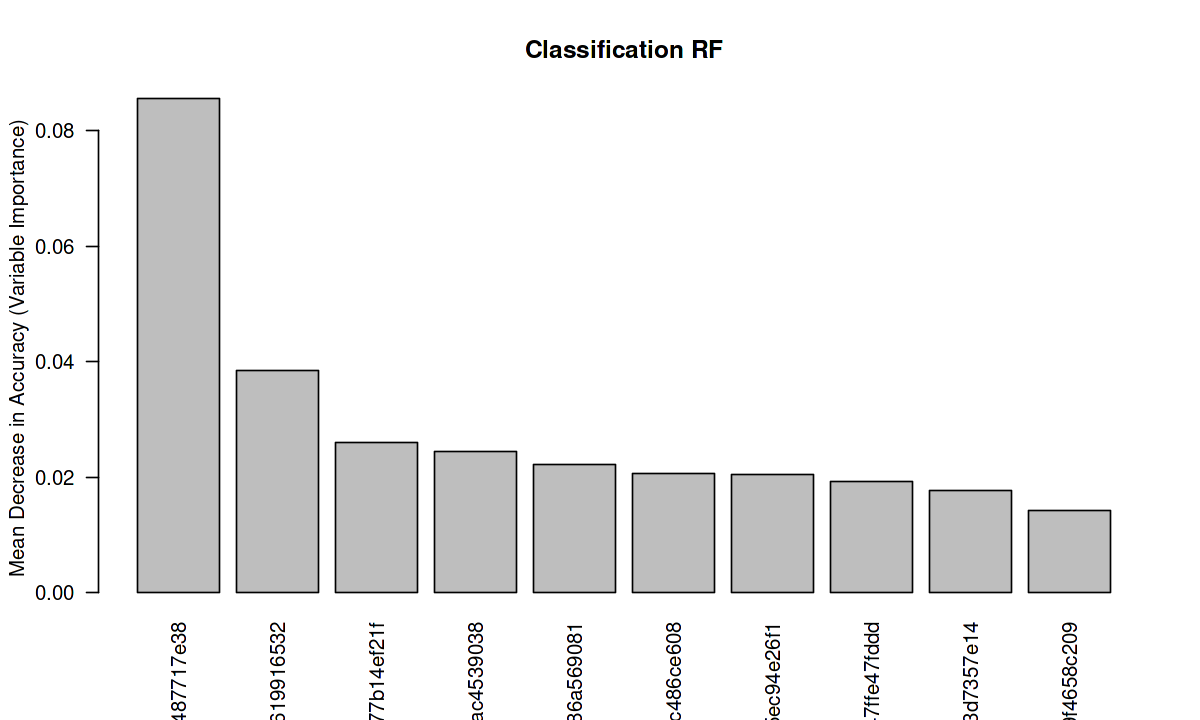

In [22]:
# Identify important features
RF_state_classify_imp <- as.data.frame(RF_state_classify$importance)
RF_state_classify_imp$features <- rownames( RF_state_classify_imp )
RF_state_classify_imp_sorted <- arrange( RF_state_classify_imp  , desc(MeanDecreaseAccuracy)  )
#barplot(RF_state_classify_imp_sorted$MeanDecreaseAccuracy, ylab="Mean Decrease in Accuracy (Variable Importance)", main="RF Classification Variable Importance Distribution")

# just look @ the top 10 features
barplot(RF_state_classify_imp_sorted[1:10,"MeanDecreaseAccuracy"], names.arg=RF_state_classify_imp_sorted[1:10,"features"] , ylab="Mean Decrease in Accuracy (Variable Importance)", las=2, main="Classification RF")  

# now what are those important features?
top_features <- RF_state_classify_imp_sorted[1:10,"features"]

top_features
# note that some are missing because R didn't like column names
# starting with numbers, so put an X infront of them. Helpful...
# I could probably gsub out the leading Xs, but what if any real OTU names start with X?
# fix it manually for now:
taxonomy %>% filter(row.names(taxonomy) %in% c(top_features,
                                               "6377e612d1fdfdadf18255fc486ce608",
                                               "5203c525a0d0a6c831885ac86a569081",
                                               "4c294f9a88e58b0e40a2b19f4658c209"))

Strong signature of *Aeromonas/Aeromonadaceae* and *Enterobacteriaceae* there. Note in the diversity-visualisations notebook we noticed similar taxa visually in the barplots changing in abundance when Oxytetracycline was present/absent.

# Summary

In summary, we can show that the composition of the communities varies when the number of chemicals is increased, and also due to the presence of specific chemicals (PERMANOVA). We can find which ASVs are most responsible for these changes (random forest).

## Next steps?

I think the follow-on from this could maybe be to build separate forests using the same input data for each response variables then somehow combine the output of the trees to create a prediction {A,C,D,G,I,M,O,T}, then try to test if the responses to combinations match the predictions?

Further thoughts:

* Which taxa are most sensitive to chemicals in general?
* Is there consistent strong influence of the chemicals on particular taxa?
* Are there correlations between taxa in responses - do particular taxa consistently increase/decrease in abundance together. Alberto's cooccurrence networks?
* Can we incorporate phylogeny into the PcoA somehow? 
* Can we use the gamma diversity of constituent communities to give prediction for higher combination of chemicals. i.e. diversity of O, diversity of T, compare to diversity of O+T